The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 图像增强
:label:`sec_image_augmentation`

在 :numref:`sec_alexnet` 中，我们提到大型数据集是各种应用程序中深度神经网络成功的先决条件。 *图片增强* 在对训练图像进行一系列随机更改之后，会生成类似但截然不同的训练示例，从而扩大了训练集的规模。或者，图像增强的动机可能是，训练示例的随机调整使模型减少了对某些属性的依赖，从而提高了它们的泛化能力。例如，我们可以用不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，从而减少模型对物体位置的依赖性。我们还可以调整亮度和颜色等因素，以降低模型对颜色的敏感度。当时，图像增强对 AleXNet 的成功可能是必不可少的。在本节中，我们将讨论这种在计算机视觉中广泛使用的技术。


In [1]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()


## 常见的图像增强方法

在我们对常见图像增强方法的调查中，我们将以下面的 $400\times 500$ 图像作为示例。


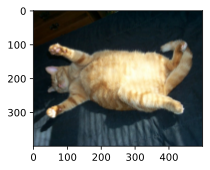

In [2]:
d2l.set_figsize()
img = image.imread('../img/cat1.jpg')
d2l.plt.imshow(img.asnumpy());

大多数图像增强方法都有一定程度的随机性。为了让我们更容易观察图像增强的效果，接下来我们定义了一个辅助函数 `apply`。此函数在输入图像 `img` 上多次运行图像增强方法 `aug` 并显示所有结果。


In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 翻转和裁剪

向左和向右翻转图像通常不会改变对象的类别。这是最早和最广泛使用的图像增强方法之一。接下来，我们使用 `transforms` 模块创建 `RandomFlipLeftRight` 实例，该实例以 50％ 的几率左右翻转图像。


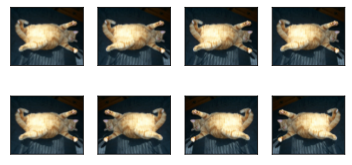

In [4]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

向上和向下翻转并不像向左和向右翻转那么常见。但至少对于这个示例图像，向上和向下翻转不会妨碍识别。接下来，我们创建一个 `RandomFlipTopBottom` 实例，以 50％ 的机会上下翻转图像。


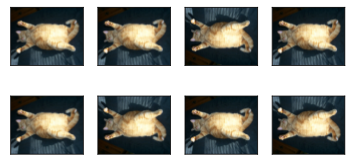

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

在我们使用的示例图片中，猫在图像的中间，但一般情况可能并非如此。在 :numref:`sec_pooling` 中，我们解释说，池层可以降低卷积层对目标位置的敏感度。此外，我们还可以随机裁剪图像，使物体以不同比例显示在图像中的不同位置，这也可以降低模型对目标位置的灵敏度。 

在下面的代码中，我们随机裁剪面积为 10 美元\%\ sim 100\ %$ of the original area each time, and the ratio of width to height of this area is randomly selected from $0.5\ sim 2$ 的区域。然后，区域的宽度和高度都将缩放到 200 像素。除非另有说明，本节中 $a$ 和 $b$ 之间的随机数是指从区间 $[a, b]$ 随机和均匀抽样获得的连续值。


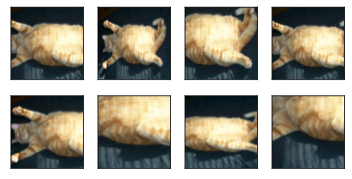

In [6]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色

另一种增强方法是改变颜色。我们可以更改图像颜色的四个方面：亮度、对比度、饱和度和色调。在下面的示例中，我们将图像的亮度随机更改为原始图像的 50% ($1-0.5$) 和 150% ($1+0.5$) 之间的值。


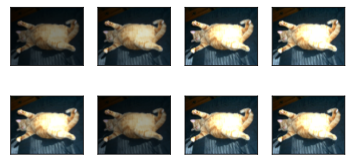

In [7]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

同样，我们可以随机改变图像的色调。


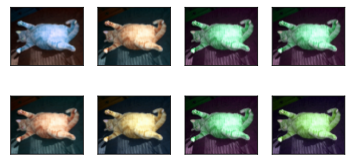

In [8]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

我们还可以创建一个 `RandomColorJitter` 实例，并设置如何同时随机更改镜像的 `brightness`、`saturation` 和 `hue`。


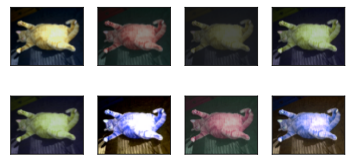

In [9]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### 叠加多个图像增强方法

实际应用中我们会将多个图像增广方法叠加使。例如，我们可以组合上面定义的不同图像增强方法，并通过 `Compose` 实例将它们应用到每个图像。


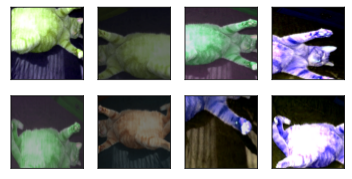

In [10]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## 使用图像增强进行训练

让我们使用图像增强来训练模型。在这里，我们使用 CIFAR-10 数据集而不是我们之前使用的 Fashion-Mnist 数据集。这是因为 Fashion-Mnist 数据集中对象的位置和大小已规范化，而 CIFAR-10 数据集中对象的颜色和大小差异更显著。CIFAR-10 数据集中的前 32 个训练图像如下所示。


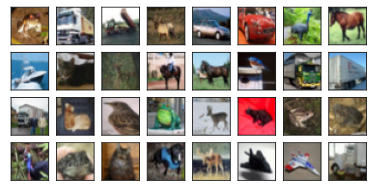

In [11]:
d2l.show_images(
    gluon.data.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);

为了在预测时获得明确的结果，我们通常只将图像增强应用于训练样本，在预测时不使用带随机操作的图像增强功能。这里我们只使用最简单的随机左右翻转。此外，我们使用 totenSor 实例将小批量图像转换为 MxNet 所需的格式，即形状为（批量大小、通道数、高度、宽度），值范围介于 0 到 1 之间，类型是 32 位浮点数。 

为了在预测期间获得明确的结果，我们通常只对训练示例应用图像增强，在预测期间不使用随机操作的图像增强功能。这里我们只使用最简单的随机左右翻转方法。此外，我们使用 `ToTensor` 实例将一批图像转换为深度学习框架所要求的格式，即介于 0 到 1 之间的 32 位浮点数，形状为（批量大小、通道数、高度、宽度）。


In [12]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

接下来，我们定义了一个辅助函数来方便读取图像和应用图像增强。Gluon 的数据集提供的 `transform_first` 函数将图像增强应用于每个训练示例的第一个元素（图像和标签），即图像。有关 `DataLoader` 的详细介绍，请参阅 :numref:`sec_fashion_mnist`。


In [13]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

### 多 GPU 训练

我们在 CIFAR-10 数据集上训练 :numref:`sec_resnet` 的 Resnet-18 模型。回想一下 :numref:`sec_multi_gpu_concise` 中对多 GPU 培训的介绍。在下面，我们定义了一个函数来使用多个 GPU 来训练和评估模型。


In [14]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, devices,
                     split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, devices)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [
            loss(pred_shard, y_shard)
            for pred_shard, y_shard in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The `True` flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(
        d2l.accuracy(pred_shard, y_shard)
        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [15]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus(), split_f=d2l.split_batch):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在我们可以定义 `train_with_data_aug` 函数来使用图像增强来训练模型。此函数获取所有可用的 GPU，使用 Adam 作为优化算法，将图像增强应用于训练数据集，最后调用刚刚定义的用于训练和评估模型的 `train_ch13` 函数。


In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增强来训练模型。


loss 0.180, train acc 0.938, test acc 0.822
3811.6 examples/sec on [gpu(0), gpu(1)]


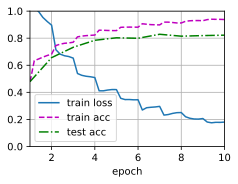

In [17]:
train_with_data_aug(train_augs, test_augs, net)

## 小结

* 图像增强基于现有训练数据生成随机图像，以提高模型的概化能力。
* 为了在预测期间获得明确的结果，我们通常只将图像增强应用于训练示例，在预测期间不会将图像增强与随机操作结合使用。
* 深度学习框架提供了许多不同的图像增强方法，这些方法可以同时应用。

## 练习

1. 在不使用图像增强的情况下训练模型：`train_with_data_aug(test_augs, test_augs)`。比较使用和不使用图像增强时的训练和测试准确性。这个比较实验能否支持图像增强可以缓解过度拟合的论点吗？为什么？
1. 在 CIFAR-10 数据集的模型训练中结合多种不同的图像增强方法。它能提高测试准确性吗？ 
1. 请参阅深度学习框架的在线文档。它还提供哪些其他图像增强方法？


[Discussions](https://discuss.d2l.ai/t/367)
